In [12]:
import random
import math
import numpy as np
import pandas as pd
import os

from IPython.display import display
from sklearn import linear_model
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import NearestNeighbors

In [163]:
def get_data():
    path = os.getcwd()+'\\data'
    name = os.listdir(path)
    name0 = []
    l = []
    for i in name:
        if i in ['ant','ivy','synapse']:
            new_path = path+'\\'+i
            output = []
            for j in os.listdir(new_path):
                data = pd.read_csv(new_path+'\\'+j,engine='python')
                output.append(data)
            output = pd.concat(output,axis=0)
            name0.append(i)
            l.append(output)
    return name0,l

## 数据集分析函数
+ 输入数据集以及Type，
+ Type == -1时，返回数据集中的（1）缺陷模块数据集（2）缺陷模块的特征数据集（3）缺陷模块的bug数据集
+ Type == 0时，返回数据集中的（1）模块特征数据集（2）模块bug数据集
+ Type == 1时，返回数据集中的（1）正常模块数据集（2）正常模块的特征数据集

In [14]:
def seperateData(modules, Type):
    if Type==-1:
        rare_modules = modules[modules.bug!=0]
        rare_char = rare_modules.iloc[:, :-1]
        rare_bug = rare_modules.iloc[:, -1]
        return rare_modules, rare_char, rare_bug
    elif Type==1:
        normal_modules = modules[modules.bug==0]
        
        normal_char = normal_modules.iloc[:, :-1]
        return normal_modules, normal_char
    else:
        char = modules.iloc[:, :-1]
        bug = modules.iloc[:, -1]
        return char, bug

## SMOTE过采样函数
+ Input:训练模块数据集，k邻近的值，从k邻近中任取n个值
+ Output：经过SMOTE过采样后的新数据集，dataframe格式，21维，包含20维的特征值和1维的bug数量

In [15]:
def smote(modules_input, ratio):
    modules, char, bug = seperateData(modules_input, -1)
    normal_modules, normal_char = seperateData(modules_input, 1)
    
    n = round((ratio*normal_modules.shape[0]-modules.shape[0])/modules.shape[0])
    k = 5
    
    if n<=0:
        return modules_input
    
    # 训练模型，取邻近的k个点（可修改邻近点数）
    neigh = NearestNeighbors(n_neighbors=k, algorithm='ball_tree', n_jobs=-1)
    neigh.fit(char)
    index = neigh.kneighbors(n_neighbors=k,return_distance=False)
    # result结果为narray类型的索引矩阵
    a, b = index.shape

    # 此处的用法详见书P83
    axis0, axis1 = np.ogrid[:a, :b]
    sort_axis = np.zeros(b,dtype=int)
    for i in range(a):
        temp = np.arange(b)
        # 从k个邻近中随机抽取n个邻近
        np.random.shuffle(temp)
        sort_axis = np.vstack((sort_axis,temp))
    # index_rand就是最终过采样得到矩阵的 下标
    sort_axis = sort_axis[1:]
    index_rand = index[axis0, sort_axis]

    flag = 0
    new_list = []
    for i in range(a):
        for j in range(n):
            p = index_rand[i][np.random.randint(0,k)]

#             p = index_rand[i][j]
            # 计算新的模块的各项特征
            new = char.iloc[i]+(char.iloc[p]-char.iloc[i])*np.random.rand()
            #计算原两个模块与新模块之间的欧氏距离
            d1 = np.linalg.norm(new-char.iloc[i])
            d2 = np.linalg.norm(new-char.iloc[p])
            if d1 == 0 and d2 == 0:
                break
            # 计算新模块的缺陷个数
            bug_new = (d2*modules.iloc[i].loc['bug']+d1*modules.iloc[p].loc['bug'])/(d1+d2)
            bug_new = float(round(bug_new))
            # 将新模块的各项特征和缺陷个数合并
            new['bug'] = bug_new
            new_list.append(new)
            flag += 1
    # 将缺陷模块数据集和正常模块数据集合并

    modules = pd.concat([modules,pd.concat(new_list,axis=1).T],axis=0)
    # modules_new的样式分为三部分，最上面时旧的缺陷数据集，中间时新合成的缺陷数据集，下面时正常数据集
    modules_new = pd.concat([modules, normal_modules], axis=0)
#     modules_new = modules_new.dropna(axis=0)
    
    return modules_new

## 决策树函数
+ Input: 训练数据集的自变量，训练数据集的因变量，测试数据集的自变量
+ Output: 测试数据集因变量，即预测出的bug数量，narray格式

In [25]:
def decisiontree(trainChar,trainBug, testChar):
    dtr = DecisionTreeRegressor()
    dtr.fit(trainChar,trainBug)
    return dtr.predict(testChar).astype(int)

In [26]:
# def decisiontree(train_data_X, train_data_y, test_data_X):
#     lr = linear_model.LinearRegression().fit(train_data_X, train_data_y)
#     return lr.predict(test_data_X).astype(int)

In [18]:
# def decisiontree(train_data_X, train_data_y, test_data_X):
#     bayes = BayesianRidge().fit(train_data_X, train_data_y)
#     return bayes.predict(test_data_X).astype(int)

## FPA计算函数
+ Input: 测试数据集的 实际 bug， 测试数据集的 预测 bug
+ Output: FPA值

In [19]:
def FPA(testBug, testPre):
    K = len(testBug)
    N = np.sum(testBug)
    
    sort_axis = np.argsort(testPre)
    testBug=np.array(testBug)
    testBug = testBug[sort_axis]
    P = sum(np.sum(testBug[m:])/N for m in range(K+1))/K
    return P

## 十折交叉验证法函数
+ Input: 总数据集
+ Output: FPA

In [20]:
def Smote_Bagging(dataset,n):
    rare_modules, rare_char, rare_bug = seperateData(dataset, -1)
    normal_modules, normal_char = seperateData(dataset, 1)
    rare_test_len = math.ceil(rare_modules.shape[0]/10)
    normal_test_len = math.ceil(normal_char.shape[0]/10)
    temp = np.array([])
    
    dataset_temp = []
    # 十折交叉验证，循环十次
    for i in range(10):
        rareX0 = i*rare_test_len
        rareX1 = (i+1)*rare_test_len
        normalX0 = i*normal_test_len
        normalX1= (i+1)*normal_test_len
        
        if rareX1 >=rare_modules.shape[0]:
            rareX1 = rare_modules.shape[0]
        if normalX1 >= normal_modules.shape[0]:
            normalX1 = normal_modules.shape[0]
         # 测试集， 取1/10的数据集
        testMod = pd.concat([rare_modules.iloc[rareX0:rareX1], normal_modules.iloc[normalX0:normalX1]],axis=0)
        # 训练集，取剩下的数据集
        trainMod = pd.concat([rare_modules.drop(rare_modules.index[list(range(rareX0,rareX1))]),normal_modules.drop(normal_modules.index[list(range(normalX0,normalX1))])],axis=0)
        dataset_temp.append(testMod)
        # 用以储存测试集预测Bug数据集
        testPre_sum = np.zeros(len(testMod))

        flag = 0
        # 每一折进行20次过采样
        for j in range(n):
            # 对训练集进行过采样
            trainMod_new = smote(trainMod,1)
            trainMod_new = trainMod_new.dropna(axis=0)
            # 提取 特征值 和 bug值
            trainChar, trainBug = seperateData(trainMod_new, 0)
            testChar, testBug = seperateData(testMod, 0)

            testPre = decisiontree(trainChar, trainBug, testChar)
            flag += 1
            testPre_sum += testPre
        # 对预测结果求平均
        testPre_sum /= flag
        temp = np.hstack((temp, testPre_sum))
    dataset_new = pd.concat(dataset_temp,axis=0)
    dataset_new['bug_new'] = temp
    P = FPA(dataset_new['bug'],dataset_new['bug_new'])
    print('{:<20}:{:>8.4f}'.format('SMOTE & Bagging',P))
    return P

In [21]:
def Smote_NoBagging(dataset):
    rare_modules, rare_char, rare_bug = seperateData(dataset, -1)
    normal_modules, normal_char = seperateData(dataset, 1)
    rare_test_len = math.ceil(rare_modules.shape[0]/10)
    normal_test_len = math.ceil(normal_char.shape[0]/10)
    temp = np.array([])
    dataset_temp = []
    
    # 十折交叉验证，循环十次
    for i in range(10):
        rareX0 = i*rare_test_len
        rareX1 = (i+1)*rare_test_len
        normalX0 = i*normal_test_len
        normalX1= (i+1)*normal_test_len
        
        if rareX1 >=rare_modules.shape[0]:
            rareX1 = rare_modules.shape[0]
        if normalX1 >= normal_modules.shape[0]:
            normalX1 = normal_modules.shape[0]
        # 测试集， 取1/10的数据集
        testMod = pd.concat([rare_modules.iloc[rareX0:rareX1], normal_modules.iloc[normalX0:normalX1]],axis=0)
        # 训练集，取剩下的数据集
        trainMod = pd.concat([rare_modules.drop(rare_modules.index[list(range(rareX0,rareX1))]),normal_modules.drop(normal_modules.index[list(range(normalX0,normalX1))])],axis=0)
        dataset_temp.append(testMod)
        
        # 用以储存测试集预测Bug数据集
        testPre_sum = np.zeros(len(testMod))

        # 对训练集进行过采样
        trainMod_new = smote(trainMod,1)
#         display(trainMod_new)
        trainMod_new = trainMod_new.dropna(axis=0)
        # 提取 特征值 和 bug值
        trainChar, trainBug = seperateData(trainMod_new, 0)
        testChar, testBug = seperateData(testMod, 0)

        testPre = decisiontree(trainChar, trainBug, testChar)

        temp = np.hstack((temp, testPre))
    dataset_new = pd.concat(dataset_temp,axis=0)
    dataset_new['bug_new'] = temp
    P = FPA(dataset_new['bug'],dataset_new['bug_new'])
    print('{:<20}:{:>8.4f}'.format('SMOTE & NoBagging',P))
    pass

In [176]:
def NoSmote_Bagging(dataset,n):
    rare_modules, rare_char, rare_bug = seperateData(dataset, -1)
    normal_modules, normal_char = seperateData(dataset, 1)
    rare_test_len = math.ceil(rare_modules.shape[0]/10)
    normal_test_len = math.ceil(normal_char.shape[0]/10)
    temp = np.array([])
    dataset_temp = []
    # 十折交叉验证，循环十次
    for i in range(10):
        rareX0 = i*rare_test_len
        rareX1 = (i+1)*rare_test_len
        normalX0 = i*normal_test_len
        normalX1= (i+1)*normal_test_len
        
        if rareX1 >=rare_modules.shape[0]:
            rareX1 = rare_modules.shape[0]
        if normalX1 >= normal_modules.shape[0]:
            normalX1 = normal_modules.shape[0]
        # 测试集， 取1/10的数据集
        testMod = pd.concat([rare_modules.iloc[rareX0:rareX1], normal_modules.iloc[normalX0:normalX1]],axis=0)
         # 训练集，取剩下的数据集
        trainMod = pd.concat([rare_modules.drop(rare_modules.index[list(range(rareX0,rareX1))]),normal_modules.drop(normal_modules.index[list(range(normalX0,normalX1))])],axis=0)
        dataset_temp.append(testMod)
        
        # 用以储存测试集预测Bug数据集
        testPre_sum = np.zeros(len(testMod))

        flag = 0
        for j in range(n):
            # 提取 特征值 和 bug值
            trainChar, trainBug = seperateData(trainMod, 0)
            testChar, testBug = seperateData(testMod, 0)

            testPre = decisiontree(trainChar, trainBug, testChar)

            flag += 1
            testPre_sum += testPre
        # 对预测结果求平均
        testPre_sum /= flag
        temp = np.hstack((temp, testPre_sum))
    dataset_new = pd.concat(dataset_temp,axis=0)
    dataset_new['bug_new'] = temp
    P = FPA(dataset_new['bug'],dataset_new['bug_new'])
    print('{:<20}:{:>8.4f}'.format('NoSMOTE & Bagging',P))
    return P
    pass

In [23]:
def NoSmote_NoBagging(dataset):
    rare_modules, rare_char, rare_bug = seperateData(dataset, -1)
    normal_modules, normal_char = seperateData(dataset, 1)
    rare_test_len = math.ceil(rare_modules.shape[0]/10)
    normal_test_len = math.ceil(normal_char.shape[0]/10)
    temp = np.array([])
    
    dataset_temp = []
    # 十折交叉验证，循环十次
    for i in range(10):
        rareX0 = i*rare_test_len
        rareX1 = (i+1)*rare_test_len
        normalX0 = i*normal_test_len
        normalX1= (i+1)*normal_test_len
        
        if rareX1 >=rare_modules.shape[0]:
            rareX1 = rare_modules.shape[0]
        if normalX1 >= normal_modules.shape[0]:
            normalX1 = normal_modules.shape[0]
        
        # 测试集， 取1/10的数据集
        testMod = pd.concat([rare_modules.iloc[rareX0:rareX1], normal_modules.iloc[normalX0:normalX1]],axis=0)
        # 训练集，取剩下的数据集
        trainMod = pd.concat([rare_modules.drop(rare_modules.index[list(range(rareX0,rareX1))]),normal_modules.drop(normal_modules.index[list(range(normalX0,normalX1))])],axis=0)
        dataset_temp.append(testMod)
        
        # 提取 特征值 和 bug值
        trainChar, trainBug = seperateData(trainMod, 0)
        testChar, testBug = seperateData(testMod, 0)

        testPre = decisiontree(trainChar, trainBug, testChar)
        temp = np.hstack((temp, testPre))
    dataset_new = pd.concat(dataset_temp,axis=0)
    dataset_new['bug_new'] = temp
    P = FPA(dataset_new['bug'],dataset_new['bug_new'])
    print('{:<20}:{:>8.4f}'.format('NoSMOTE & NoBagging',P))
    pass

In [177]:
final_output = []
for (i,j) in zip(*get_data()):
    l = []
    print(i)
    if j.shape[1] == 24:
        j = j.drop(j.columns[[0,1,2]], axis=1)
    else:
        j = j.drop(j.columns[[0,1,2,3]], axis=1)
    for k in line:
        print(k)
        temp = NoSmote_Bagging(j,k)
        l.append(temp)
    final_output.append(l)

ant
1
NoSMOTE & Bagging   :  0.6937
2
NoSMOTE & Bagging   :  0.7139
3
NoSMOTE & Bagging   :  0.7272
4
NoSMOTE & Bagging   :  0.7215
5
NoSMOTE & Bagging   :  0.7259
6
NoSMOTE & Bagging   :  0.7232
7
NoSMOTE & Bagging   :  0.7329
8
NoSMOTE & Bagging   :  0.7274
9
NoSMOTE & Bagging   :  0.7321
10
NoSMOTE & Bagging   :  0.7316
15
NoSMOTE & Bagging   :  0.7248
20
NoSMOTE & Bagging   :  0.7320
25
NoSMOTE & Bagging   :  0.7297
30
NoSMOTE & Bagging   :  0.7250
35
NoSMOTE & Bagging   :  0.7330
40
NoSMOTE & Bagging   :  0.7308
45
NoSMOTE & Bagging   :  0.7292
ivy
1
NoSMOTE & Bagging   :  0.6964
2
NoSMOTE & Bagging   :  0.7110
3
NoSMOTE & Bagging   :  0.7294
4
NoSMOTE & Bagging   :  0.7236
5
NoSMOTE & Bagging   :  0.7502
6
NoSMOTE & Bagging   :  0.7345
7
NoSMOTE & Bagging   :  0.7316
8
NoSMOTE & Bagging   :  0.7388
9
NoSMOTE & Bagging   :  0.7501
10
NoSMOTE & Bagging   :  0.7506
15
NoSMOTE & Bagging   :  0.7501
20
NoSMOTE & Bagging   :  0.7531
25
NoSMOTE & Bagging   :  0.7491
30
NoSMOTE & Bagging

In [179]:
for i in final_output:
    print(i)
# print(final_output)

[0.69365394821322124, 0.71392293960682818, 0.72721385335366229, 0.72154955817569655, 0.72594646150877296, 0.72318436376187523, 0.73289856040615697, 0.72736787022501159, 0.73207559073820594, 0.73158848918727482, 0.72477927341148873, 0.73197260355314886, 0.72974863704347204, 0.72495741340725572, 0.73298113571669909, 0.73083510545516794, 0.72919287736917371]
[0.69643452028427855, 0.71097220165827557, 0.72940572253479408, 0.72359897838318055, 0.7501711948474985, 0.73445828397986712, 0.73157573289902345, 0.73880293159609289, 0.75010641841871528, 0.75059224163458749, 0.75011567219425512, 0.75310464169381175, 0.74911626443588841, 0.74644192330470926, 0.74755237636955774, 0.74629848978382973, 0.7462938628960607]
[0.623212004159859, 0.64514039518645305, 0.6325360273362064, 0.64145595008171075, 0.6278294458475705, 0.64004754122715557, 0.6334868518793616, 0.6355548952607335, 0.63085425642549564, 0.63036101619372975, 0.63222106670628442, 0.63648194919031498, 0.63144852176496824, 0.6320368444510486

In [180]:
y = pd.DataFrame(final_output,index=['ant','ivy','synapse'],columns=line)
display(y)

,1,2,3,4,5,6,7,8,9,10,15,20,25,30,35,40,45
ant,0.693654,0.713923,0.727214,0.721550,0.725946,0.723184,0.732899,0.727368,0.732076,0.731588,0.724779,0.731973,0.729749,0.724957,0.732981,0.730835,0.729193
ivy,0.696435,0.710972,0.729406,0.723599,0.750171,0.734458,0.731576,0.738803,0.750106,0.750592,0.750116,0.753105,0.749116,0.746442,0.747552,0.746298,0.746294
synapse,0.623212,0.645140,0.632536,0.641456,0.627829,0.640048,0.633487,0.635555,0.630854,0.630361,0.632221,0.636482,0.631449,0.632037,0.632179,0.632839,0.633439


In [186]:
z = (np.array(x)-np.array(y))/np.array(y)

In [190]:
z = pd.DataFrame(z,index=['ant','ivy','synapse'],columns=line)

In [165]:
line = list(range(1,10))
line[len(line):len(line)]=list(range(10,50,5))

In [168]:
print(line)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45]


In [128]:
import matplotlib.pyplot as plt
%matplotlib inline

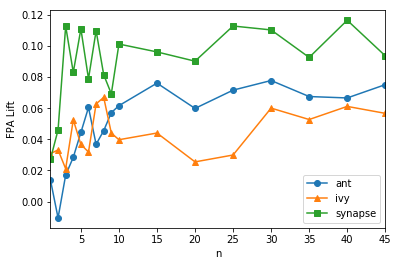

In [192]:
z.T.iloc[:,0].plot(style='-o')
z.T.iloc[:,1].plot(style='-^')
z.T.iloc[:,2].plot(style='-s')
plt.xlabel('n')
plt.ylabel('FPA Lift')
plt.legend(z.index)
plt.savefig('n_test.svg')
# plt.show()